In [1]:
import numpy as np

roiMap1 = np.zeros(265,dtype='int')
roiMap2 = np.zeros(265,dtype='int')
revMap2 = np.zeros(264,dtype='int')
roiNames = {}
borders1 = []
borders2 = []

with open('../../PNC/PP264_template.csv', 'r') as f:
    lines = f.readlines()
    for i in range(2,len(lines)):
        line = lines[i].split(',')
        area = int(line[11])
        r1 = int(line[0])
        r2 = int(line[1])
        name = line[14].strip()
        roiMap1[r1] = area
        roiMap2[r2] = area
        roiNames[area] = name
        revMap2[r1-1] = r2-1
#         print([area, r1, r2, name])
        
last1 = roiMap1[1]
last2 = roiMap2[1]
for i in range(2,265):
    if roiMap1[i] != last1:
        borders1.append(i)
        last1 = roiMap1[i]
    if roiMap2[i] != last2:
        borders2.append(i)
        last2 = roiMap2[i]
    
borders1 = [0] + borders1 + [264]
print(borders1)
print(borders2)

[0, 31, 36, 50, 63, 121, 126, 157, 182, 200, 213, 222, 233, 237, 264]
[13, 42, 47, 61, 74, 84, 86, 132, 133, 137, 138, 139, 140, 143, 174, 182, 186, 203, 221, 222, 235, 243, 247, 251, 253, 255, 256]


In [2]:
import pickle

with open('../../PNC_Good/MegaMeta3.pkl', 'rb') as f: 
    meta = pickle.load(f)
    
print('Complete')

Complete


In [3]:
with open('../../Work/LatentSim/Splits.pkl', 'rb') as f:
    keys, groups = pickle.load(f)
    
print(len(keys))
print(len(groups[0][0])+len(groups[0][1]))
print('Complete')

620
620
Complete


In [4]:
import numpy as np

nback = np.stack([meta[key]['nback'] for key in keys])
emoid = np.stack([meta[key]['emoid'] for key in keys])

print(nback.shape)
print(emoid.shape)

(620, 264, 231)
(620, 264, 210)


In [5]:
from nilearn.connectome import ConnectivityMeasure

def getFC(timeSeries, kind='correlation', transpose=True):
    connMeasure = ConnectivityMeasure(kind=kind)
    if transpose:
        timeSeries = np.transpose(timeSeries, axes=(0,2,1))
    return connMeasure.fit_transform(timeSeries)

nback_p = getFC(nback)
emoid_p = getFC(emoid)

print(nback_p.shape)

(620, 264, 264)


In [242]:
def rearrange(p,idcs):
    return p[:,idcs,:][:,:,idcs]

def maskRegion(p, borders1, reg):
    p = p.copy()
    p[:,borders1[reg]:borders1[reg+1],:] = 0
    p[:,:,borders1[reg]:borders1[reg+1]] = 0
    return p
    
nback_p_msk = maskRegion(rearrange(nback_p, revMap2), borders1, 4)
emoid_p_msk = maskRegion(rearrange(emoid_p, revMap2), borders1, 4)

print('Complete')

Complete


In [243]:
import torch

def convertTorch(p, sz, offset):
    idx, idy = torch.triu_indices(sz,sz,offset=offset)
    u = torch.zeros(p.shape[0],idx.shape[0])
    u = torch.from_numpy(p).float()[:,idx,idy]
    return u.cuda()

def convertTorchBack(p, sz, offset):
    idx, idy = torch.triu_indices(sz,sz,offset=offset)
    if p.dim() == 1:
        p = p.unsqueeze(0)
    u = torch.zeros(p.shape[0],sz,sz).float().cuda()
    u[:,idx,idy] = p
    u = u + u.permute(0,2,1) - u*torch.eye(sz).float().cuda().unsqueeze(0)
    if u.shape[0] == 1:
        u = u.squeeze(0)
    return u.detach().cpu()

nback_p_t = convertTorch(nback_p_msk,264,1)
emoid_p_t = convertTorch(emoid_p_msk,264,1)

print(nback_p_t.shape)
print(emoid_p_t.shape)
print('Complete')

torch.Size([620, 34716])
torch.Size([620, 34716])
Complete


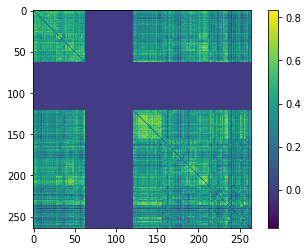

In [244]:
import matplotlib.pyplot as plt

plt.imshow(convertTorchBack(nback_p_t[0],264,1))
plt.colorbar()
plt.show()

In [249]:
mu_nback = torch.mean(nback_p_t, dim=0, keepdim=True)
mu_emoid = torch.mean(emoid_p_t, dim=0, keepdim=True)
std_nback = torch.std(nback_p_t, dim=0, keepdim=True)
std_emoid = torch.std(emoid_p_t, dim=0, keepdim=True)

nback_p_t = (nback_p_t - mu_nback)/std_nback
emoid_p_t = (emoid_p_t - mu_emoid)/std_emoid

nback_p_t[torch.isnan(nback_p_t)] = 0
emoid_p_t[torch.isnan(emoid_p_t)] = 0

print('Norm complete')

Norm complete


In [250]:
print(torch.min(nback_p_t[:,9990:10000],dim=0))
print(torch.min(emoid_p_t[:,9990:10000],dim=0))

torch.return_types.min(
values=tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0'),
indices=tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'))
torch.return_types.min(
values=tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0'),
indices=tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'))


In [25]:
age = np.stack([meta[key]['AgeInMonths'] for key in keys])
gen = np.stack([np.array([meta[key]['Gender'] == 'M', meta[key]['Gender'] == 'F']) for key in keys]).astype(int)
wrt = np.stack([meta[key]['wratStd'] for key in keys])

print(age.shape)
print(gen.shape)
print(wrt.shape)

(620,)
(620, 2)
(620,)


In [26]:
age_t = torch.from_numpy(age).float().cuda()
gen_t = torch.from_numpy(gen).float().cuda()
wrt_t = torch.from_numpy(wrt).float().cuda()

print('Complete')

Complete


In [292]:
import torch.nn as nn
import torch.nn.functional as F
import time

def arith(n):
    return int(n*(n+1)/2)

def mask(e):
    return e - torch.diag(torch.diag(e.detach()))

class LatSim(nn.Module):
    def __init__(self, nTgts, dp=0.5, dp2=0.1, method='same'):
        super(LatSim, self).__init__()
        self.nTgts = nTgts
        self.method = method
        self.masks = []
        if method == 'same':
            nMasks = nTgts
        elif method == 'diff':
            nMasks = 2*nTgts
        elif method == 'univ':
            nMasks = nTgts+1
        for i in range(nMasks):
            self.masks.append(nn.Parameter(
                1e-4*torch.randn(arith(263),2).float().cuda()
            ))
        self.masks = nn.ParameterList(self.masks)
        self.dp = nn.Dropout(p=dp)
        self.dp2 = nn.Dropout(p=dp2)
        self.ln = nn.LayerNorm((nTgts, nback_p_t.shape[1])).cuda()
    
    def getLatentsAndEdges(self, x, i):
        if self.method == 'univ':
            y = torch.einsum('ac,ce->ae', x, self.masks[0])
            z = torch.einsum('ac,ce->ae', x, self.masks[i+1])
            e = y@z.T
            e = e+e.T
            return y, z, e
        elif self.method == 'diff':
            y = torch.einsum('ac,ce->ae', x, self.masks[2*i])
            z = torch.einsum('ac,ce->ae', x, self.masks[2*i+1])
            e = y@z.T
            e = e+e.T
            return y, z, e
        elif self.method == 'same':
            y = torch.einsum('ac,ce->ae', x, self.masks[i])
            e = y@y.T+1e-10
            return y, y, e
        
    def forward(self, x, y, testIdcs=None):
        x = self.dp(x)
        res = []
        es = []
        for i in range(self.nTgts):
            nClass = y.shape[1] if y.dim() == 2 else 1
            _, _, e = self.getLatentsAndEdges(x[:,i,:], i)
            if testIdcs is not None:
                e[:,testIdcs] = 0
            e = self.dp2(e)
            e = mask(e)
            e[e == 0] = float('-inf')
            e = F.softmax(e, dim=1)
            es.append(e)
            res.append(e@y)
        return res, es

def validate(model, X, y, testIdcs):
    model.eval()
    with torch.no_grad():
        res, _ = model(X, y, testIdcs)
        avg = torch.mean(torch.stack(res), dim=0)
        if res[0].dim() == 1:
            loss = mseLoss(avg[testIdcs], y[testIdcs]).cpu().numpy()**0.5
        else:
            corr = (torch.argmax(avg, dim=1) == torch.argmax(y, dim=1))[testIdcs]
            loss = torch.sum(corr)/len(testIdcs)
    model.train()
    return loss
        
ceLoss = torch.nn.CrossEntropyLoss()
mseLoss = torch.nn.MSELoss()
nEpochs = 200
pPeriod = 10
thresh = 0.1

para = [nback_p_t, emoid_p_t]
rmse = []
simMap = []
# mat = mats[0]

X = torch.stack(para, dim=1)

t = time.time()
for i in range(10):
    sim = LatSim(len(para), 0.5, 0.1, 'same') # 0.2 wrat, 0.1 other
    optim = torch.optim.Adam(sim.parameters(), lr=1e-4, weight_decay=1e-4) 

    trainIdcs = groups[i][0][0:496]
    validIdcs = groups[i][0]
    testIdcs = groups[i][1]
    
    Xt = X[trainIdcs]
    Xv = X[validIdcs]
    
    trainLoss = []
    validLoss = []
    
    vIdcs1 = np.arange(496,len(validIdcs))
    vIdcs2 = validIdcs[496:]
    vIdcs3 = np.concatenate([testIdcs, vIdcs2])

    var = gen_t
    
    for epoch in range(nEpochs):
        optim.zero_grad()
        res, _ = sim(Xt, var[trainIdcs])
        avg = torch.mean(torch.stack(res), dim=0)
        loss = 0
        for r in res + [avg]:
            loss += ceLoss(r, var[trainIdcs])
        loss = torch.stack([loss/(len(res)+1)])
        torch.sum(loss).backward()
        optim.step()
        if epoch % pPeriod == 0 or epoch == nEpochs-1 or torch.all(loss[0:3] < thresh):
            print(f'epoch {epoch} loss={(float(loss))}')
            lossV = validate(sim, Xv, var[validIdcs], vIdcs1)
            if len(validLoss) == 0 or lossV > max(validLoss):
                print(f'New best validation epoch {epoch} loss={lossV}')
                torch.save(sim.state_dict(), '../../Work/LatentSim/sim.pyt')
            validLoss.append(lossV)
            if torch.all(loss[0:3] < thresh):
                print('Early stopping')
                break
            
    print('Finished training')
    
    sim.load_state_dict(torch.load('../../Work/LatentSim/sim.pyt'))
    loss = validate(sim, X, var, testIdcs)

    rmse.append((float(loss)))
        
    print(i, end=' ')
    print(rmse[-1])
    
    continue
    
    Y0 = torch.einsum('ab,bc->abc', nback_p_t, sim.masks[0])
    Y1 = torch.einsum('ab,bc->abc', emoid_p_t, sim.masks[1])

    print(Y0.shape)
    print(Y1.shape)

    idcs = torch.argsort(var) if var is age_t or var is wrt_t else torch.argsort(var[:,0])
    Y0sort = Y0[idcs,:,:]
    Y1sort = Y1[idcs,:,:]

    simMapPart = []
    step = 100

    for Y in [Y0sort, Y1sort]:
        parts = []
        for j in range(0,40000,step):
            if j >= Y.shape[1]:
                break
            part = Y[:,j:j+step,:]
            subConnSim = torch.einsum('abc,dbc->adb', part, part)
            subConnR = torch.einsum('adb,ad->b', subConnSim, mat)
            parts.append(subConnR.detach().cpu().numpy())

        parts = np.concatenate(parts)
        simMapPart.append(parts)

    simMap.append(np.stack(simMapPart))
    print('Complete')
    
print(time.time()-t)

epoch 0 loss=0.6928145885467529
New best validation epoch 0 loss=0.5806451439857483
epoch 10 loss=0.5419191122055054
New best validation epoch 10 loss=0.6935483813285828
epoch 20 loss=0.4090591073036194
New best validation epoch 20 loss=0.7258064150810242
epoch 30 loss=0.351909875869751
New best validation epoch 30 loss=0.7903225421905518
epoch 40 loss=0.3301343619823456
epoch 50 loss=0.32450616359710693
epoch 60 loss=0.32147014141082764
epoch 70 loss=0.31882208585739136
epoch 80 loss=0.31960150599479675
epoch 90 loss=0.3150463104248047
epoch 100 loss=0.31505274772644043
epoch 110 loss=0.31500503420829773
epoch 120 loss=0.3148397207260132
epoch 130 loss=0.3142647445201874
epoch 140 loss=0.31476786732673645
epoch 150 loss=0.3143561780452728
epoch 160 loss=0.3140279948711395
epoch 170 loss=0.31433793902397156
epoch 180 loss=0.31393903493881226
epoch 190 loss=0.3139391839504242
epoch 199 loss=0.31407129764556885
Finished training
0 0.8548386693000793
epoch 0 loss=0.691146731376648
New bes

epoch 100 loss=0.31478118896484375
epoch 110 loss=0.31523022055625916
epoch 120 loss=0.3142818808555603
epoch 130 loss=0.31416451930999756
epoch 140 loss=0.31435346603393555
epoch 150 loss=0.31387537717819214
epoch 160 loss=0.3137657344341278
epoch 170 loss=0.31395217776298523
epoch 180 loss=0.31387656927108765
epoch 190 loss=0.3146704435348511
epoch 199 loss=0.3138575255870819
Finished training
8 0.7419354915618896
epoch 0 loss=0.6916636228561401
New best validation epoch 0 loss=0.6451612710952759
epoch 10 loss=0.5280740261077881
New best validation epoch 10 loss=0.7580645084381104
epoch 20 loss=0.397937536239624
New best validation epoch 20 loss=0.774193525314331
epoch 30 loss=0.34785041213035583
epoch 40 loss=0.3284915089607239
epoch 50 loss=0.32304027676582336
epoch 60 loss=0.32085126638412476
New best validation epoch 60 loss=0.7903225421905518
epoch 70 loss=0.31860384345054626
epoch 80 loss=0.3176570534706116
epoch 90 loss=0.31835681200027466
epoch 100 loss=0.31780263781547546
ep

In [293]:
for a in rmse:
    print(a)

print('---')
print(sum(rmse)/len(rmse))

0.8548386693000793
0.8064515590667725
0.7580645084381104
0.7903225421905518
0.8064515590667725
0.7096773982048035
0.8064515590667725
0.8064515590667725
0.7419354915618896
0.7258064150810242
---
0.7806451261043549


In [247]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn.dense import DenseGCNConv
import time

def arith(n):
    return int(n*(n+1)/2)

class GCN(nn.Module):
    def __init__(self, nTgt, dp=0.5):
        super(GCN, self).__init__()
        self.gcn = []
        for i in range(2*nTgt):
            self.gcn.append(DenseGCNConv(arith(263),40).float().cuda())
            self.gcn.append(DenseGCNConv(40,1).float().cuda())
        self.gcn = nn.ModuleList(self.gcn)
        self.dp = nn.Dropout(p=dp)
        
    def forward(self, x):
        e = torch.ones(x.shape[0], x.shape[0]).float().cuda()/x.shape[0]
        x = self.dp(x)
        res = []
        for i in range(x.shape[1]):
            y = F.relu(self.gcn[2*i](x[:,i,:],e)).squeeze()
            y = self.gcn[2*i+1](y,e).squeeze()
            res.append(y)
        return res
    
class MLP(nn.Module):
    def __init__(self, nTgt, dp=0.5):
        super(MLP, self).__init__()
        self.lin = []
        for i in range(2*nTgt):
            self.lin.append(nn.Linear(arith(263),40).float().cuda())
            self.lin.append(nn.Linear(40,1).float().cuda())
        self.lin = nn.ModuleList(self.lin)
        self.dp = nn.Dropout(p=dp)
        
    def forward(self, x):
        x = self.dp(x)
        res = []
        for i in range(x.shape[1]):
            y = F.relu(self.lin[2*i](x[:,i,:])).squeeze()
            y = self.lin[2*i+1](y).squeeze()
            res.append(y)
        return res
    
def validate(model, X, y, testIdcs):
    model.eval()
    with torch.no_grad():
        res = model(X)
        avg = torch.mean(torch.stack(res), dim=0)
        if res[0].dim() == 1:
            loss = mseLoss(avg[testIdcs], y[testIdcs]).cpu().numpy()**0.5
        else:
            corr = (torch.argmax(avg, dim=1) == torch.argmax(y, dim=1))[testIdcs]
            loss = torch.sum(corr)/len(testIdcs)
    model.train()
    return loss
    
ceLoss = torch.nn.CrossEntropyLoss()
mseLoss = torch.nn.MSELoss()
nEpochs = 15000
pPeriod = 500
thresh = 100

para = [nback_p_t, emoid_p_t]
# para = [nback_pp_t, emoid_pp_t]
rmse = []

X = torch.stack(para, dim=1)

t = time.time()
for i in range(10):
    gcn0 = GCN(2, 0.5) #Guys(X, 2, 2, 0.5)
    params = list(gcn0.parameters())
    optim = torch.optim.Adam(params, lr=1e-4, weight_decay=1e-4) # 2e-4

    trainIdcs = groups[i][0][0:496]
    validIdcs = groups[i][0]
    testIdcs = groups[i][1]
    
    Xt = X[trainIdcs]
    Xv = X[validIdcs]
    
    trainLoss = []
    validLoss = []
    
    val = wrt_t
    
    for epoch in range(nEpochs):
        optim.zero_grad()
        res = gcn0(Xt)
        avg = torch.mean(torch.stack(res), dim=0)
        loss0 = 0
        for r in res + [avg]:
            loss0 += mseLoss(r, val[trainIdcs])/(len(res)+1)
        loss = torch.stack([loss0])
        torch.sum(loss).backward()
        optim.step()
        if epoch % pPeriod == 0 or epoch == nEpochs-1 or torch.all(loss[0:3] < thresh):
            print(f'epoch {epoch} loss={(float(loss0))}')
            lossV = validate(gcn0, Xv, val[validIdcs], np.arange(496,len(validIdcs)))
            if len(validLoss) == 0 or lossV < min(validLoss):
                print(f'New best validation epoch {epoch} loss={lossV}')
                torch.save(gcn0.state_dict(), '../../Work/LatentSim/gcn.pyt')
            validLoss.append(lossV)
            if torch.all(loss[0:3] < thresh):
                print('Early stopping')
                break
            
    print('Finished training')
    
    gcn0.load_state_dict(torch.load('../../Work/LatentSim/gcn.pyt'))
    loss0 = validate(gcn0, X, val, testIdcs)

    rmse.append((float(loss0)))
        
    print(i, end=' ')
    print(rmse[-1])
    
print(time.time()-t)

epoch 0 loss=10877.7978515625
New best validation epoch 0 loss=98.37029266357422
epoch 500 loss=336.6432189941406
New best validation epoch 500 loss=13.635519027709961
epoch 1000 loss=312.5218505859375
New best validation epoch 1000 loss=13.072120666503906
epoch 1500 loss=287.3596496582031
New best validation epoch 1500 loss=12.478398323059082
epoch 2000 loss=263.35186767578125
New best validation epoch 2000 loss=12.006697654724121
epoch 2500 loss=241.86964416503906
New best validation epoch 2500 loss=11.695666313171387
epoch 3000 loss=224.899658203125
New best validation epoch 3000 loss=11.52430248260498
epoch 3500 loss=206.46343994140625
New best validation epoch 3500 loss=11.444504737854004
epoch 4000 loss=188.09327697753906
New best validation epoch 4000 loss=11.36236572265625
epoch 4500 loss=167.95968627929688
New best validation epoch 4500 loss=11.27652645111084
epoch 5000 loss=144.96029663085938
epoch 5500 loss=125.2615966796875
New best validation epoch 5500 loss=11.06083583831

epoch 6322 loss=99.59222412109375
Early stopping
Finished training
6 15.86292839050293
epoch 0 loss=10901.2998046875
New best validation epoch 0 loss=99.24347686767578
epoch 500 loss=329.6352844238281
New best validation epoch 500 loss=13.880545616149902
epoch 1000 loss=313.54290771484375
New best validation epoch 1000 loss=13.492873191833496
epoch 1500 loss=292.79302978515625
New best validation epoch 1500 loss=13.023749351501465
epoch 2000 loss=270.32421875
New best validation epoch 2000 loss=12.527300834655762
epoch 2500 loss=246.80120849609375
New best validation epoch 2500 loss=12.078177452087402
epoch 3000 loss=226.26205444335938
New best validation epoch 3000 loss=11.783209800720215
epoch 3500 loss=208.9999542236328
New best validation epoch 3500 loss=11.63533878326416
epoch 4000 loss=189.91786193847656
New best validation epoch 4000 loss=11.55593490600586
epoch 4500 loss=169.11338806152344
New best validation epoch 4500 loss=11.539436340332031
epoch 5000 loss=148.5989532470703


In [248]:
for a in rmse:
    print(a)

print('---')
print(sum(rmse)/len(rmse))

12.397627830505371
13.4342679977417
12.477546691894531
15.067265510559082
14.035831451416016
14.166891098022461
15.86292839050293
14.823467254638672
15.177753448486328
15.86279010772705
---
14.330636978149414


/home/anton/.conda/envs/torch/lib/python3.7/site-packages/ipykernel_launcher.py:50: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


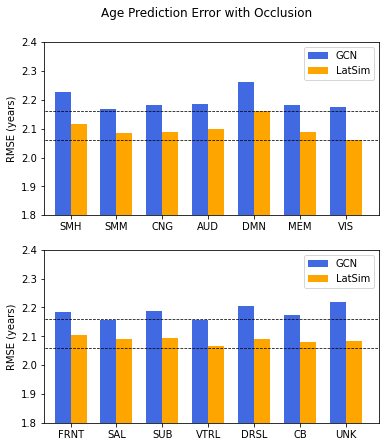

In [320]:
import numpy as np
import matplotlib.pyplot as plt

N = 7
gcn = [2.227099705,2.169204632,2.180862013,2.187328021,
       2.262813107,2.180744807,2.177101517,2.184996367,
       2.155422195,2.18737429,2.157745981,2.203852272,
       2.174140247,2.219887336]
sim = [2.117077923,2.085857153,2.090040716,2.097972266,
       2.160446548,2.088599682,2.061520243,2.105823962,
       2.089234352,2.093923871,2.067402776,2.090685813,
       2.080230316,2.085290003]

ind = np.arange(N)  # the x locations for the groups
width = 0.35        # the width of the bars

fig, ax = plt.subplots(2,1,figsize=(6,7))
rects1 = ax[0].bar(ind, gcn[:7], width, color='royalblue')
rects2 = ax[0].bar(ind+width, sim[:7], width, color='orange')

# add some
ax[0].set_ylabel('RMSE (years)')
ax[0].set_xticks(ind + width / 2)
ax[0].set_xticklabels( ('SMH', 'SMM', 'CNG', 'AUD', 'DMN', 'MEM', 'VIS'))

ax[0].legend( (rects1[0], rects2[0]), ('GCN', 'LatSim') )

rects1 = ax[1].bar(ind, gcn[7:], width, color='royalblue')
rects2 = ax[1].bar(ind+width, sim[7:], width, color='orange')

# add some
ax[1].set_ylabel('RMSE (years)')
ax[1].set_xticks(ind + width / 2)
ax[1].set_xticklabels( ('FRNT', 'SAL', 'SUB', 'VTRL', 'DRSL', 'CB', 'UNK'))

ax[1].legend( (rects1[0], rects2[0]), ('GCN', 'LatSim') )

ax[0].set_ylim(1.8,2.4)
ax[1].set_ylim(1.8,2.4)
ax[0].set_xlim(-.4,6.9)
ax[1].set_xlim(-.4,6.9)

ax[0].plot([-1,7],2*[2.06],linestyle='dashed',color='black',linewidth=0.75)
ax[1].plot([-1,7],2*[2.06],linestyle='dashed',color='black',linewidth=0.75)
ax[0].plot([-1,7],2*[2.16],linestyle='dashed',color='black',linewidth=0.75)
ax[1].plot([-1,7],2*[2.16],linestyle='dashed',color='black',linewidth=0.75)

fig.suptitle('Age Prediction Error with Occlusion', y=0.95)

fig.show()
fig.savefig('../../Work/LatentSim/Occlusion.png', format='png', bbox_inches='tight')